In [ ]:
import numpy as np
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Concatenate, Input
from tensorflow.keras.callbacks import EarlyStopping


HPARAMS = {
    "embedding_dim": [64, 100],
    "max_len": [60, 100, 150],
    "rnn_units": [32, 64],
    "dropout": [0.3, 0.5]
}

max_words = 10000
batch_size = 32
epochs = 10
RANDOM_STATE = 42


In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www.\S+", " link ", text)
    text = re.sub(r"\S+@\S+", " email ", text)
    text = re.sub(r"\d+", " number ", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def get_extra_features(df):
    features = pd.DataFrame()
    features['length'] = df['text'].apply(len)
    features['words'] = df['text'].apply(lambda x: len(x.split()))
    features['upper_ratio'] = df['text'].apply(lambda x: sum(1 for c in x if c.isupper())/max(1,len(x)))
    features['excl_count'] = df['text'].apply(lambda x: x.count('!'))
    features['digit_count'] = df['text'].apply(lambda x: sum(1 for c in x if c.isdigit()))
    spam_keywords = ['free', 'win', 'winner', 'cash', 'credit', 'urgent', 'call', 'claim', 'click', 'buy', 'prize', 'offer']
    features['spam_keyword_count'] = df['text'].apply(lambda x: sum(1 for kw in spam_keywords if kw in x))
    return features

def load_dataset(path, type):
    if type == 'sms':
        df = pd.read_csv(path, encoding='latin-1')
        # Otomatik kolon adı düzeltmesi
        if 'label' in df.columns and 'message' in df.columns:
            df = df[['label', 'message']]
            df.columns = ['label', 'text']
        elif 'v1' in df.columns and 'v2' in df.columns:
            df = df[['v1', 'v2']]
            df.columns = ['label', 'text']
        else:
            raise Exception(f"{path} için uygun kolon bulunamadı. Kolonlar: {df.columns}")
    elif type == 'email':
        df = pd.read_csv(path)
        if 'label' in df.columns and 'text' in df.columns:
            df = df[['label', 'text']]
        else:
            raise Exception(f"{path} için uygun kolon bulunamadı. Kolonlar: {df.columns}")
    df = df[df['label'].isin(['spam', 'ham'])]
    df['label'] = (df['label'] == 'spam').astype(int)
    df['text'] = df['text'].astype(str).apply(clean_text)
    df = df[df['text'].str.strip() != ""]
    df = df.dropna()
    return df


In [ ]:
def build_rnn_model(max_words, embedding_dim, max_len, rnn_units, dropout_rate, extra_feat_dim):
    # Metin girişi
    text_in = Input(shape=(max_len,), name="text_in")
    emb = Embedding(input_dim=max_words, output_dim=embedding_dim)(text_in)
    rnn = SimpleRNN(rnn_units, dropout=dropout_rate, return_sequences=False)(emb)

    # Ekstra öznitelik girişi
    extra_in = Input(shape=(extra_feat_dim,), name="extra_in")
    extra_dense = Dense(16, activation='relu')(extra_in)

    # Birleştir
    concat = Concatenate()([rnn, extra_dense])
    dense = Dense(32, activation='relu')(concat)
    dropout = Dropout(0.3)(dense)
    out = Dense(1, activation='sigmoid')(dropout)

    model = Model(inputs=[text_in, extra_in], outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [ ]:
def run_grid_search(df, hparams, print_reports=True):
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['text'])
    extra_feats = get_extra_features(df)
    scaler = StandardScaler()
    extra_feats_scaled = scaler.fit_transform(extra_feats)
    y = df['label'].values

    best_auc = 0
    best_model = None
    best_params = None
    results = []

    for embedding_dim in hparams['embedding_dim']:
        for max_len in hparams['max_len']:
            for rnn_units in hparams['rnn_units']:
                for dropout_rate in hparams['dropout']:
                    sequences = tokenizer.texts_to_sequences(df['text'])
                    X = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

                    X_train, X_test, ex_train, ex_test, y_train, y_test = train_test_split(
                        X, extra_feats_scaled, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
                    )

                    model = build_rnn_model(
                        max_words, embedding_dim, max_len, rnn_units, dropout_rate, ex_train.shape[1]
                    )
                    es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=0)

                    hist = model.fit(
                        [X_train, ex_train], y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_split=0.1,
                        callbacks=[es],
                        verbose=0
                    )

                    y_pred_prob = model.predict([X_test, ex_test], batch_size=128, verbose=0)
                    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
                    auc = roc_auc_score(y_test, y_pred_prob)
                    f1 = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']

                    results.append({
                        "embedding_dim": embedding_dim,
                        "max_len": max_len,
                        "rnn_units": rnn_units,
                        "dropout": dropout_rate,
                        "roc_auc": auc,
                        "f1": f1
                    })

                    if auc > best_auc:
                        best_auc = auc
                        best_model = model
                        best_params = {
                            "embedding_dim": embedding_dim,
                            "max_len": max_len,
                            "rnn_units": rnn_units,
                            "dropout": dropout_rate
                        }
                        best_X_test = X_test
                        best_ex_test = ex_test
                        best_y_test = y_test
                        best_y_pred = y_pred
                        best_y_pred_prob = y_pred_prob
                        best_hist = hist

    results_df = pd.DataFrame(results)
    if print_reports:
        print("Grid Search Sonuçları:\n", results_df.sort_values("roc_auc", ascending=False).head(10))
        print("\nEn iyi parametreler:\n", best_params)
        print("\nTest Sınıflandırma Raporu:")
        print(classification_report(best_y_test, best_y_pred, digits=4))
        print("Confusion Matrix:")
        print(confusion_matrix(best_y_test, best_y_pred))
        print("ROC-AUC: ", roc_auc_score(best_y_test, best_y_pred_prob))

        plt.figure(figsize=(8,3))
        plt.subplot(1,2,1)
        plt.plot(best_hist.history['accuracy'], label='train')
        plt.plot(best_hist.history['val_accuracy'], label='val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1,2,2)
        plt.plot(best_hist.history['loss'], label='train')
        plt.plot(best_hist.history['val_loss'], label='val')
        plt.title('Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()

    return best_model, best_params, results_df



Dataset: data/spam.csv (sms)
Grid Search Sonuçları:
     embedding_dim  max_len  rnn_units  dropout   roc_auc        f1
8              64      150         32      0.3  0.964704  0.948463
15            100       60         64      0.5  0.962673  0.953138
16            100      100         32      0.3  0.954251  0.945135
6              64      100         64      0.3  0.954223  0.944479
1              64       60         32      0.5  0.953705  0.945884
2              64       60         64      0.3  0.952742  0.941522
20            100      150         32      0.3  0.952283  0.944002
11             64      150         64      0.5  0.952269  0.945667
21            100      150         32      0.5  0.951747  0.942512
23            100      150         64      0.5  0.950847  0.939913

En iyi parametreler:
 {'embedding_dim': 64, 'max_len': 150, 'rnn_units': 32, 'dropout': 0.3}

Test Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0     0.9680    0.973

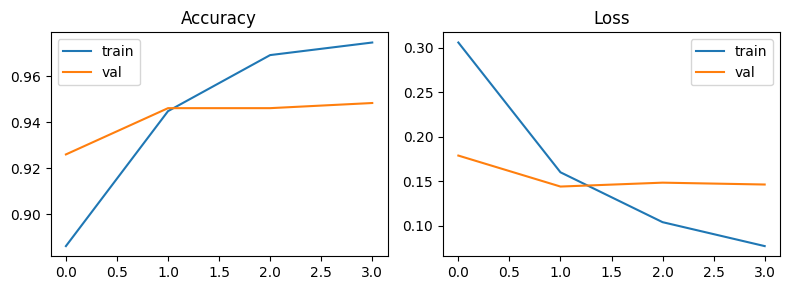


Dataset: data/spam_ham_dataset.csv (email)
Grid Search Sonuçları:
     embedding_dim  max_len  rnn_units  dropout   roc_auc        f1
14            100       60         64      0.3  0.992966  0.975972
0              64       60         32      0.3  0.990041  0.966233
15            100       60         64      0.5  0.988653  0.955142
3              64       60         64      0.5  0.984980  0.950797
2              64       60         64      0.3  0.981828  0.950749
12            100       60         32      0.3  0.978712  0.928602
4              64      100         32      0.3  0.972902  0.942411
1              64       60         32      0.5  0.970943  0.927355
13            100       60         32      0.5  0.970363  0.959171
5              64      100         32      0.5  0.932739  0.899428

En iyi parametreler:
 {'embedding_dim': 100, 'max_len': 60, 'rnn_units': 64, 'dropout': 0.3}

Test Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0     0

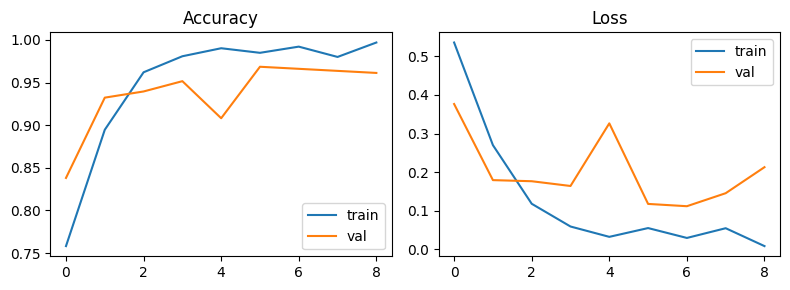

In [ ]:
datasets = [
    ("data/spam.csv", "sms"),
    ("data/spam_ham_dataset.csv", "email")
]

for path, dtype in datasets:
    print(f"\n{'='*60}\nDataset: {path} ({dtype})\n{'='*60}")
    df = load_dataset(path, dtype)
    best_model, best_params, results_df = run_grid_search(df, HPARAMS, print_reports=True)
    # best_model.save(f"models/rnn_{dtype}.h5")  # Modeli kaydetmek istersen açabilirsin.
